# 1. **Load and Data preparation**

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [8]:
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
departments = pd.read_csv("departments.csv")
order_products = pd.read_csv("order_products__prior.csv")


In [9]:
merged = order_products.merge(products, on="product_id") \
                       .merge(departments, on="department_id")

In [10]:
df = pd.read_csv('orders.csv')
df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [11]:
df.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

In [12]:
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


# **Explotory Data Analysis**

**Pick Day of Week and Peak Hour of the Day**

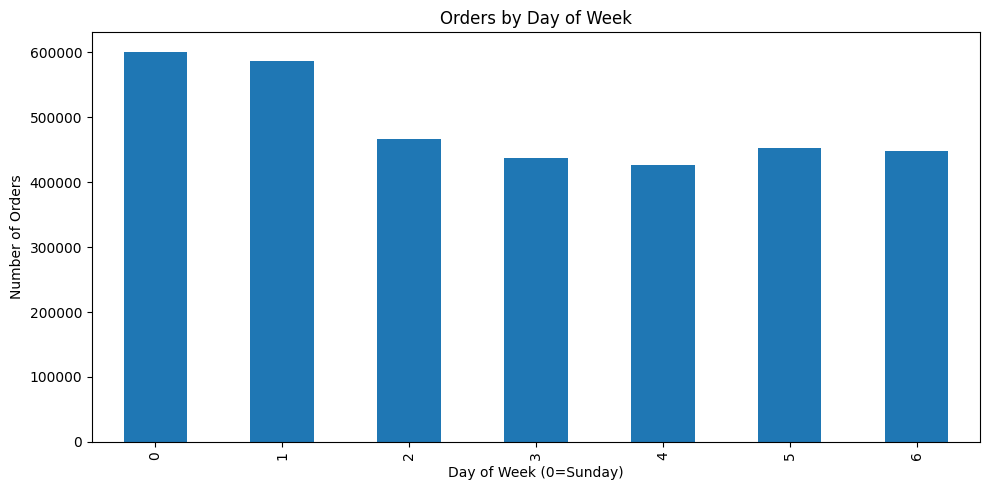

In [13]:
# --- Orders by Day of Week ---
plt.figure(figsize=(10,5))
df['order_dow'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Day of Week (0=Sunday)')
plt.ylabel('Number of Orders')
plt.title('Orders by Day of Week')
plt.tight_layout()
plt.show()

**Pick Hours of the Day**

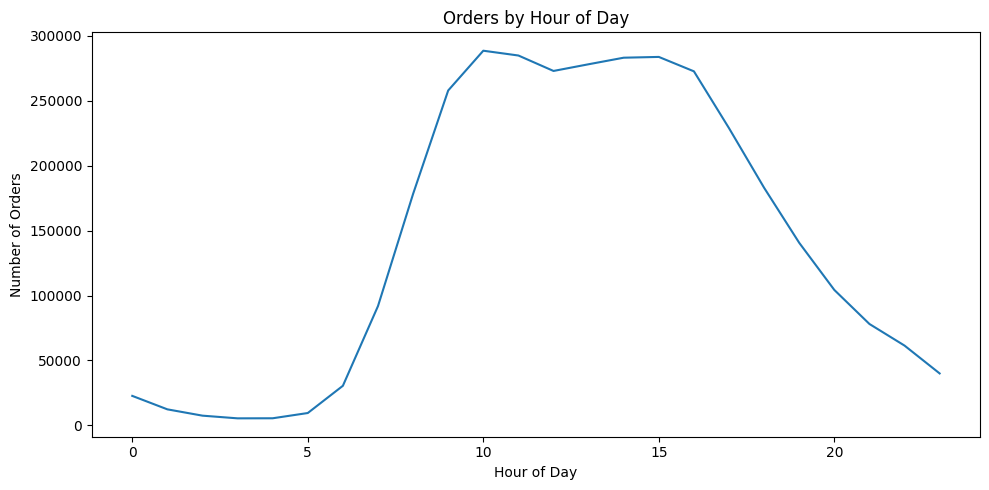

In [14]:
# --- Orders by Hour of Day ---
plt.figure(figsize=(10,5))
df['order_hour_of_day'].value_counts().sort_index().plot()
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.title('Orders by Hour of Day')
plt.tight_layout()
plt.show()

**What items are the most relevant?**

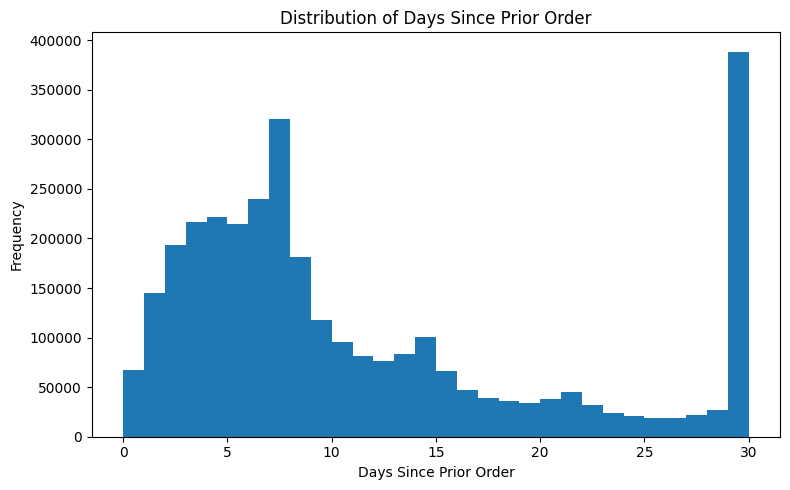

In [15]:
plt.figure(figsize=(8,5))
df['days_since_prior_order'].dropna().plot(kind='hist', bins=30)
plt.xlabel('Days Since Prior Order')
plt.ylabel('Frequency')
plt.title('Distribution of Days Since Prior Order')
plt.tight_layout()
plt.show()

**Heatmap: Orders by Day of Week × Hour of Day**


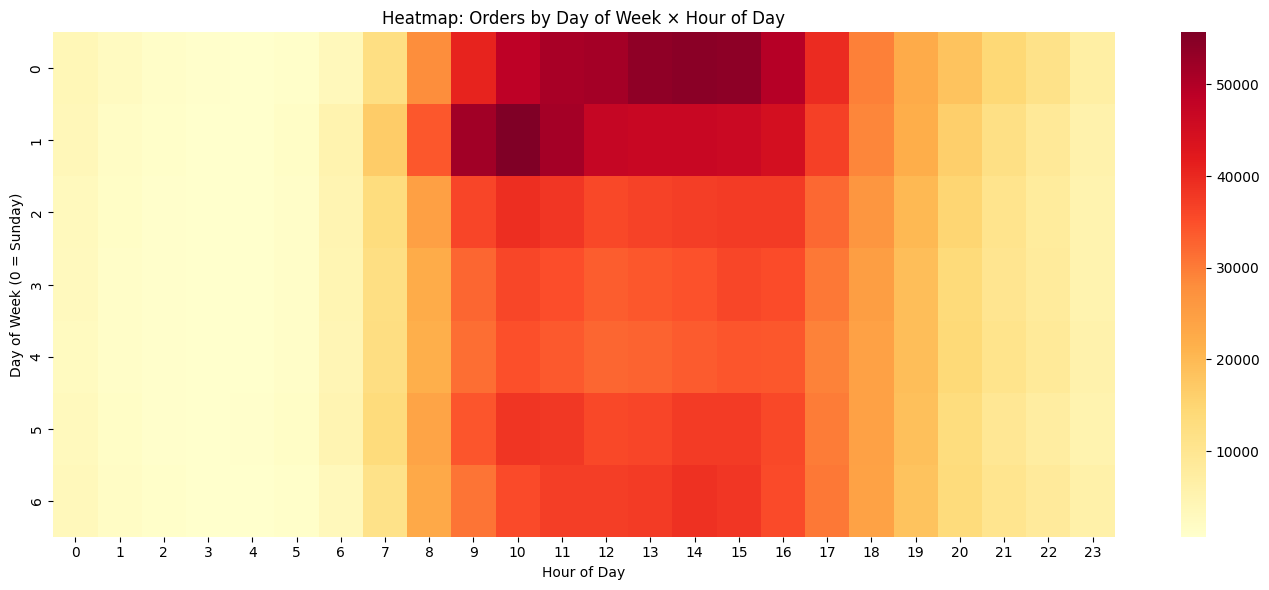

In [16]:
heat = df.pivot_table(
    index='order_dow',
    columns='order_hour_of_day',
    values='order_id',
    aggfunc='count'
)

plt.figure(figsize=(14,6))
sns.heatmap(heat, cmap='YlOrRd')
plt.title('Heatmap: Orders by Day of Week × Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0 = Sunday)')
plt.tight_layout()
plt.show()

**Number of Orders per User**

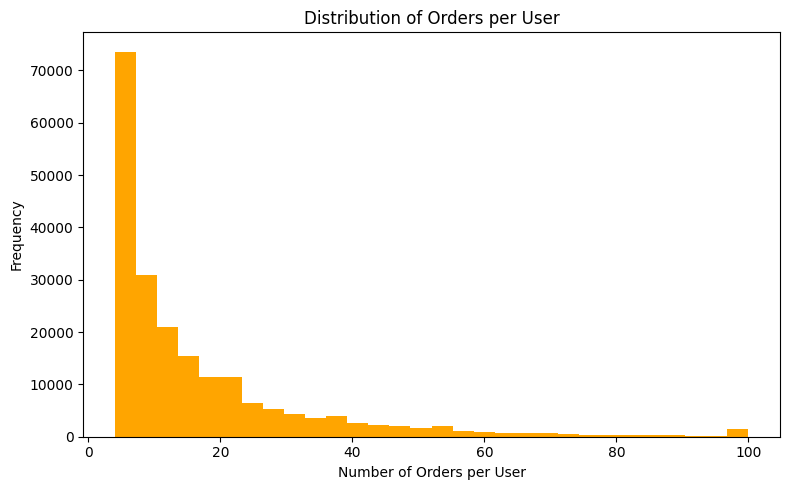

In [17]:
user_orders = df.groupby('user_id')['order_id'].count()

plt.figure(figsize=(8,5))
user_orders.plot(kind='hist', bins=30, color='orange')
plt.xlabel('Number of Orders per User')
plt.ylabel('Frequency')
plt.title('Distribution of Orders per User')
plt.tight_layout()
plt.show()

**Department Breakdown**

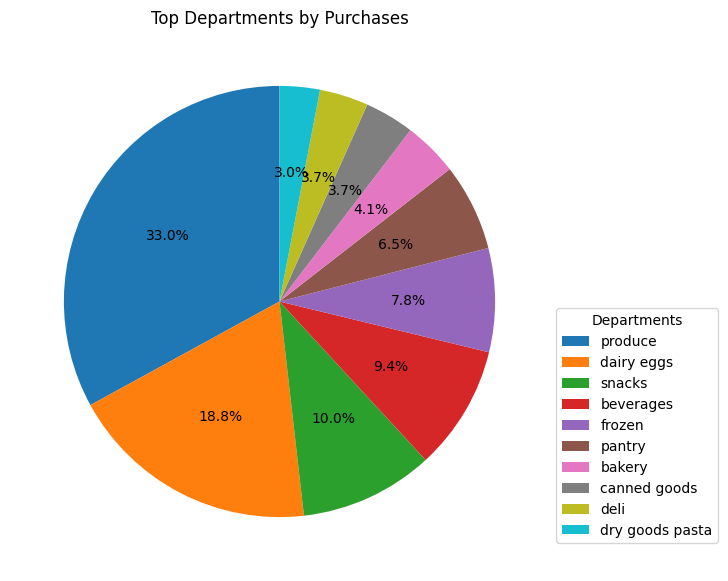

In [18]:
dept_counts = merged['department'].value_counts().head(10)

plt.figure(figsize=(7,7))
plt.pie(dept_counts, autopct='%1.1f%%', startangle=90)
plt.legend(dept_counts.index, title="Departments", loc="best", bbox_to_anchor=(1, 0.5))
plt.title('Top Departments by Purchases')
plt.show()

**Top 20 Most Popular Products**

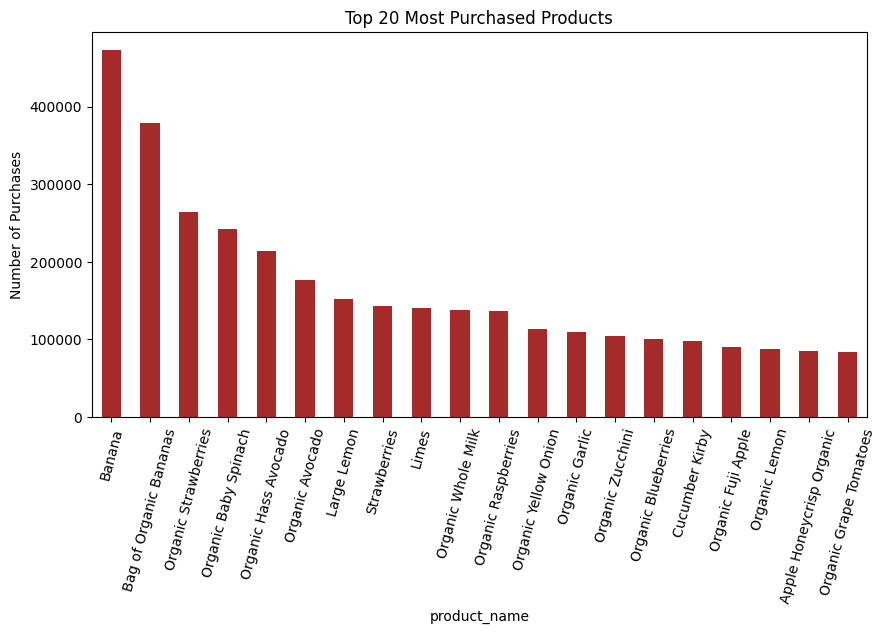

In [19]:
top_products = merged['product_name'].value_counts().head(20)

plt.figure(figsize=(10,5))
top_products.plot(kind='bar', color='brown')
plt.ylabel('Number of Purchases')
plt.title('Top 20 Most Purchased Products')
plt.xticks(rotation=75)
plt.show()

# **Model Selection and Predictive Task**


In [20]:
# Keep only columns we need from orders
orders_small = orders[[
    "order_id",
    "user_id",
    "eval_set",
    "order_number",
    "order_dow",
    "order_hour_of_day",
    "days_since_prior_order"
]]

In [21]:
# Split orders by eval_set
prior_orders = orders_small[orders_small["eval_set"] == "prior"]
train_orders = orders_small[orders_small["eval_set"] == "train"]


In [23]:
prior = pd.read_csv("order_products__prior.csv")

In [24]:
# Merge prior order_products with prior orders to attach user & order info
prior_merged = prior.merge(
    prior_orders.drop(columns=["eval_set"]),
    on="order_id",
    how="left"
)

In [25]:
print("Building user-level features...")

Building user-level features...


In [26]:
# --- User-level features ---
user_group = prior_merged.groupby("user_id")

user_features = pd.DataFrame({
    "user_total_orders": user_group["order_number"].max(),
    "user_total_items": user_group.size(),
    "user_avg_basket_size": user_group.size() / user_group["order_number"].nunique(),
    "user_mean_days_since_prior": user_group["days_since_prior_order"].mean(),
    "user_reorder_ratio": user_group["reordered"].mean()
}).reset_index()

print("Building product-level features...")

Building product-level features...


In [27]:
# --- Product-level features ---
prod_group = prior_merged.groupby("product_id")

product_features = pd.DataFrame({
    "product_total_purchases": prod_group.size(),
    "product_reorder_ratio": prod_group["reordered"].mean(),
    "product_mean_add_to_cart_order": prod_group["add_to_cart_order"].mean()
}).reset_index()

print("Building user-product interaction features...")

Building user-product interaction features...


In [28]:
# --- User-product interaction features ---
up_group = prior_merged.groupby(["user_id", "product_id"])

user_product_features = pd.DataFrame({
    "up_order_count": up_group.size(),
    "up_last_order_number": up_group["order_number"].max(),
    "up_avg_add_to_cart_order": up_group["add_to_cart_order"].mean()
}).reset_index()


**Training Sset**

In [30]:
train_op = pd.read_csv("order_products__train.csv")

In [31]:
# Attach user_id to train_op via orders
train_orders_small = train_orders.drop(columns=["eval_set"])
train_set = train_op.merge(
    train_orders_small,
    on="order_id",
    how="left"
)

# Merge engineered features
train_set = train_set.merge(user_features, on="user_id", how="left")
train_set = train_set.merge(product_features, on="product_id", how="left")
train_set = train_set.merge(user_product_features,
                            on=["user_id", "product_id"],
                            how="left")

# Some interactions may be missing (product never seen in prior),
# fill with 0 where appropriate
for col in ["up_order_count", "up_last_order_number", "up_avg_add_to_cart_order"]:
    train_set[col] = train_set[col].fillna(0)

# For user/product-level NaNs (rare), fill with mean or 0
num_cols = [
    "user_total_orders",
    "user_total_items",
    "user_avg_basket_size",
    "user_mean_days_since_prior",
    "user_reorder_ratio",
    "product_total_purchases",
    "product_reorder_ratio",
    "product_mean_add_to_cart_order"
]

for col in num_cols:
    train_set[col] = train_set[col].fillna(train_set[col].median())

# Also keep basic order-level features
train_set["days_since_prior_order"] = train_set["days_since_prior_order"].fillna(0)

feature_cols = [
    # Order-level
    "order_dow",
    "order_hour_of_day",
    "days_since_prior_order",

    # User-level
    "user_total_orders",
    "user_total_items",
    "user_avg_basket_size",
    "user_mean_days_since_prior",
    "user_reorder_ratio",

    # Product-level
    "product_total_purchases",
    "product_reorder_ratio",
    "product_mean_add_to_cart_order",

    # User-product interaction
    "up_order_count",
    "up_last_order_number",
    "up_avg_add_to_cart_order"
]

In [32]:
X = train_set[feature_cols]
y = train_set["reordered"]

**Train/ Validation**

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

**Models**  
Logistic Regression

In [34]:
models = {}

models["log_reg"] = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)


Random Forest

In [35]:
models["random_forest"] = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42
)

XGBoost

In [ ]:
models["xgboost"] = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

In [36]:
results = []

print("Training and evaluating models...")

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds)
    print(f"{name} F1-score: {f1:.4f}")
    results.append((name, f1))

Training and evaluating models...

Training log_reg...
log_reg F1-score: 1.0000

Training random_forest...
random_forest F1-score: 1.0000


In [37]:
# Sort models by F1
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

print("\nModel comparison (sorted by F1):")
for name, f1 in results_sorted:
    print(f"{name:15s}  F1 = {f1:.4f}")

best_model_name, best_f1 = results_sorted[0]
best_model = models[best_model_name]

print(f"\nBest model: {best_model_name} with F1 = {best_f1:.4f}")



Model comparison (sorted by F1):
log_reg          F1 = 1.0000
random_forest    F1 = 1.0000

Best model: log_reg with F1 = 1.0000
